In [1]:
import numpy as np
from sklearn_ensemble_cv import Ensemble, comp_empirical_ecv, ECV

We make up some fake data for illustration.

In [2]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=300, n_features=100,
                       n_informative=10, n_targets=1,
                       random_state=0, shuffle=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# The Ensemble class

For users who want to have more control of the ensemble predictor, this section introduces lower-level class and object that we use to implement the cross-validation methods.
For users who just want to use easy interface functions, you can safely skip this section.

We provide `Ensemble` a class for ensemble predictor, whose base class is `sklearn.ensemble.BaggingRegressor`.
This means that the usage of `Ensemble` is basically the same as the latter, except the new class includes several new member functions that we will illustrate below.



## Initialize an object

The initialization of `Ensemble` class is the same as `sklearn.ensemble.BaggingRegressor`, where 

1. The base estimator object, whose hyperparameter `kwargs_regr` is specified when it is initialized. In the following example, we use decision tree as the base estimator. 
2. The hyperparameters for building an ensemble, such as `n_estimators`, `max_samples`, `max_features`, and etc.

In [3]:
from sklearn.tree import DecisionTreeRegressor
kwargs_regr = {'max_depth': 7}
kwargs_ensemble = {'max_samples': 0.8}
regr = Ensemble(estimator=DecisionTreeRegressor(**kwargs_regr), n_estimators=100, **kwargs_ensemble)

After the ensemble object `regr` is initialized, we can fit the data and get the prediction:

In [4]:
regr.fit(X_train, y_train)
regr.predict(X_test)

array([-1.48971825e+01, -1.81074553e+02, -6.45055025e+01, -2.49633520e+01,
        8.19405289e+00, -6.70936022e+01,  4.23672780e+01, -9.83271604e+01,
       -2.73863670e+01,  9.74759783e+01,  2.55298554e+01, -1.67097408e+02,
        2.11009743e+02, -4.61761100e+01,  1.20132745e+02,  5.31496667e+01,
       -2.57083921e-01, -8.72360751e+01, -2.17965098e+01,  5.36073675e+01,
       -2.38015331e+01, -9.66415623e+01, -5.07674372e+00,  6.73467603e+01,
        1.57607852e+01, -1.64855168e+01,  3.35996112e+01, -4.79645104e+01,
        2.65711134e+01, -5.51757447e+01, -7.56320895e+01,  4.82636716e+01,
       -8.82144892e+01, -2.35666654e+01, -8.10866986e+01, -8.44832537e+00,
       -3.25827828e+01,  1.23400731e+02,  2.20078859e+02,  8.99470383e+01,
        1.50881615e+02,  1.18589777e+02,  1.64650570e+01,  8.92456543e+01,
        9.34084258e+01, -7.60445425e+01,  1.55967571e+02,  8.59515168e+01,
       -1.73785480e+02, -2.77044770e+01,  1.10049276e+02, -1.76663914e+02,
        7.63654939e+01,  

## Prediction of individual estimators

We provide a new function `predict_individual` to obtain prediction values from all estimators in the ensemble.
Since we have $n=150$ observations and $M=10$ estimators, the resulting prediction would be of shape $(n,M)=(150,10)$.

In [5]:
Y_train_hat = regr.predict_individual(X_train)
Y_train_hat.shape

(150, 100)

## Compute ECV estimate of the prediction risk

Below, we use function `compute_ecv_estimate` to estimate the prediction risk for various ensemble size $M=1,\ldots,100$, only using the first $M_0=20$ trees.

In [6]:
df_est = regr.compute_ecv_estimate(X_train, y_train, M0=20, return_df=True)
df_est

,M,estimate
0,1,52909.865655
1,2,37286.529942
2,3,32078.751371
3,4,29474.862085
4,5,27912.528514
...,...,...
95,96,21988.680389
96,97,21985.324862
97,98,21982.037815
98,99,21978.817172


We can also compute the test error on the test set using function `compute_risk`. 

In [7]:
df_risk = regr.compute_risk(X_test, y_test, return_df=True)
df_risk

,M,risk
0,1,52225.622719
1,2,41656.631392
2,3,40991.760198
3,4,33746.938617
4,5,28170.455135
...,...,...
95,96,23515.793601
96,97,23475.493083
97,98,23509.963282
98,99,23547.927684


If we plot both the risk estimate and the actual test error, we see a close match.

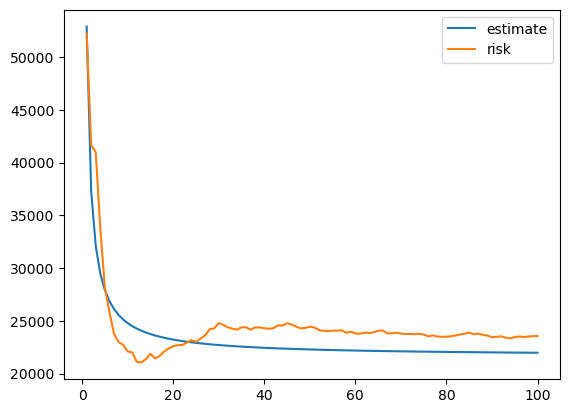

In [8]:
import matplotlib.pyplot as plt
plt.plot(df_est['M'], df_est['estimate'], label='estimate')
plt.plot(df_risk['M'], df_risk['risk'], label='risk')
plt.legend()
plt.show()

Above we show two basic functions and their usage.
One utility of ECV method is that we can also get a risk estimate beyond $M=100$, which gives us a sense how much improvement one can get if we further increase the ensemble size.

In [9]:
df_est = regr.compute_ecv_estimate(X_train, y_train, M_test=1000, M0=20, return_df=True)
df_est

,M,estimate
0,1,52909.865655
1,2,37286.529942
2,3,32078.751371
3,4,29474.862085
4,5,27912.528514
...,...,...
995,996,21694.566389
996,997,21694.534922
997,998,21694.503519
998,999,21694.472178


# ECV estimate for one configuration of ensemble predictors


The function `comp_empirical_ecv` provides an easy way to fit and get risk estimate from ECV.
Similar to the previous section, one need to provide
1. Data: `X_train, y_train`.
2. A regressor class and the parameters to initialize it: `DecisionTreeRegressor, kwargs_regr=kwargs_regr`.
3. The parameters for building the ensemble (with `M` denoting `n_estimators`): `kwargs_ensemble=kwargs_ensemble, M=100`.
4. Extra optional parameters for ECV.

The function returns two objects:
1. An ensemble predictor (an object of `Ensemble`)
2. A np.array or pd.DataFrame object, containing the risk estimates given by ECV.

In [10]:
from sklearn.tree import DecisionTreeRegressor
kwargs_regr = {'max_depth': 7}
kwargs_ensemble = {'max_samples': 0.8}
regr, risk_ecv = comp_empirical_ecv(X_train, y_train, DecisionTreeRegressor, kwargs_regr=kwargs_regr,
                   kwargs_ensemble=kwargs_ensemble, M=100)

One can also pass kwargs `X_val=X_test, Y_val=y_test` to get the actual test errors.

# ECV for tuning hyperparameters

For tuning hyperparameters, such as `max_samples` and `max_features` for the ensemble predictors, and `max_depth` and `min_samples_leaf` for all base predictors, we can make two grids of these two types of tuning hyperparameters respectively.

We recommend using `np.array` for each parameter, and make sure to use the correct dtypes that `sklearn` accept.
If one want to set some hyperparameter to a fix value, simply provide it in the grid as either a scalar or a list/array with length one.

In [11]:
# Hyperparameters for the base regressor
grid_regr = {    
    'max_depth':np.array([6,7], dtype=int), 
    }
# Hyperparameters for the ensemble
grid_ensemble = {
    'max_features':np.array([0.9,1.]),
    'max_samples':np.array([0.6,0.7]),
}

res_ecv, info_ecv = ECV(
    X_train, y_train, DecisionTreeRegressor, grid_regr, grid_ensemble, M=100,  return_df=True
)

In [12]:
res_ecv

,max_depth,max_features,max_samples,risk_val-1,risk_val-2,risk_val-3,risk_val-4,risk_val-5,risk_val-6,risk_val-7,...,risk_val-91,risk_val-92,risk_val-93,risk_val-94,risk_val-95,risk_val-96,risk_val-97,risk_val-98,risk_val-99,risk_val-100
0,6,0.9,0.6,82353.888267,61451.036847,54483.419707,50999.611137,48909.325995,47515.802567,46520.428689,...,41007.588754,41002.595240,40997.709113,40992.926946,40988.245456,40983.661498,40979.172054,40974.774231,40970.465253,40966.242455
1,6,0.9,0.7,80737.150480,60580.714110,53861.901987,50502.495925,48486.852288,47143.089864,46183.259560,...,40867.276342,40862.461140,40857.749490,40853.138089,40848.623769,40844.203498,40839.874367,40835.633585,40831.478475,40827.406468
2,6,1.0,0.6,56002.876479,38094.286526,32124.756542,29139.991550,27349.132554,26155.226558,25302.436560,...,20579.291957,20575.013746,20570.827540,20566.730402,20562.719520,20558.792197,20554.945851,20551.178001,20547.486269,20543.868372
3,6,1.0,0.7,55704.430084,37994.405217,32091.063594,29139.392783,27368.390296,26187.721972,25344.387454,...,20673.611665,20669.380890,20665.241099,20661.189389,20657.222978,20653.339200,20649.535501,20645.809428,20642.158629,20638.580846
4,7,0.9,0.6,82905.755658,60492.847702,53021.878383,49286.393723,47045.102927,45550.909064,44483.627732,...,38572.531128,38567.176874,38561.937765,38556.810127,38551.790439,38546.875327,38542.061558,38537.346030,38532.725764,38528.197904
5,7,0.9,0.7,82850.955301,60946.155292,53644.555289,49993.755288,47803.275287,46342.955286,45299.869572,...,39522.779460,39517.546588,39512.426251,39507.414858,39502.508968,39497.705284,39493.000645,39488.392018,39483.876496,39479.451284
6,7,1.0,0.6,56452.372986,38485.495975,32496.536972,29502.057470,27705.369769,26507.577969,25652.012397,...,20913.495383,20909.203248,20905.003417,20900.892944,20896.869007,20892.928903,20889.070037,20885.289924,20881.586177,20877.956505
7,7,1.0,0.7,54492.245476,37431.483033,31744.562219,28901.101812,27195.025568,26057.641405,25245.224146,...,20745.682402,20741.606731,20737.618708,20733.715536,20729.894537,20726.153141,20722.488888,20718.899416,20715.382458,20711.935839


In [13]:
info_ecv

{'delta': 0.0,
 'best_params_regr': {'max_depth': 6},
 'best_params_ensemble': {'max_features': 1.0, 'max_samples': 0.6},
 'best_n_estimators': inf,
 'M_max': inf}

# SplitCV

In [14]:
from sklearn_ensemble_cv.cross_validation import splitCV
res_splitcv, info_splitcv = splitCV(
        X_train, y_train, DecisionTreeRegressor, grid_regr, grid_ensemble,
        M=20, return_df=True, random_state=0, test_size=0.25,
        )

In [15]:
res_splitcv

,max_depth,max_features,max_samples,risk_val-1,risk_val-2,risk_val-3,risk_val-4,risk_val-5,risk_val-6,risk_val-7,...,risk_val-11,risk_val-12,risk_val-13,risk_val-14,risk_val-15,risk_val-16,risk_val-17,risk_val-18,risk_val-19,risk_val-20
0,6,0.9,0.6,74826.816228,50785.81057,39089.927604,29734.691062,26680.992931,22295.529558,21294.852061,...,20200.401571,20576.493428,20651.058828,20056.571606,19447.809438,19345.350257,19333.12386,19048.520412,19182.63404,19470.412376
1,6,0.9,0.7,74826.816228,50785.81057,39089.927604,29734.691062,26680.992931,22295.529558,21294.852061,...,20200.401571,20576.493428,20651.058828,20056.571606,19447.809438,19345.350257,19333.12386,19048.520412,19182.63404,19470.412376
2,6,1.0,0.6,74826.816228,50785.81057,39089.927604,29734.691062,26680.992931,22295.529558,21294.852061,...,20200.401571,20576.493428,20651.058828,20056.571606,19447.809438,19345.350257,19333.12386,19048.520412,19182.63404,19470.412376
3,6,1.0,0.7,74826.816228,50785.81057,39089.927604,29734.691062,26680.992931,22295.529558,21294.852061,...,20200.401571,20576.493428,20651.058828,20056.571606,19447.809438,19345.350257,19333.12386,19048.520412,19182.63404,19470.412376
4,7,0.9,0.6,74826.816228,50785.81057,39089.927604,29734.691062,26680.992931,22295.529558,21294.852061,...,20200.401571,20576.493428,20651.058828,20056.571606,19447.809438,19345.350257,19333.12386,19048.520412,19182.63404,19470.412376
5,7,0.9,0.7,74826.816228,50785.81057,39089.927604,29734.691062,26680.992931,22295.529558,21294.852061,...,20200.401571,20576.493428,20651.058828,20056.571606,19447.809438,19345.350257,19333.12386,19048.520412,19182.63404,19470.412376
6,7,1.0,0.6,74826.816228,50785.81057,39089.927604,29734.691062,26680.992931,22295.529558,21294.852061,...,20200.401571,20576.493428,20651.058828,20056.571606,19447.809438,19345.350257,19333.12386,19048.520412,19182.63404,19470.412376
7,7,1.0,0.7,74826.816228,50785.81057,39089.927604,29734.691062,26680.992931,22295.529558,21294.852061,...,20200.401571,20576.493428,20651.058828,20056.571606,19447.809438,19345.350257,19333.12386,19048.520412,19182.63404,19470.412376


In [16]:
info_splitcv

{'best_params_regr': {'max_depth': 6},
 'best_params_ensemble': {'max_features': 0.9, 'max_samples': 0.6},
 'split_params': {'index_train': array([ 61,  92, 112,   2, 141,  43,  10,  60, 116, 144, 119, 108,  69,
         135,  56,  80, 123, 133, 106, 146,  50, 147,  85,  30, 101,  94,
          64,  89,  91, 125,  48,  13, 111,  95,  20,  15,  52,   3, 149,
          98,   6,  68, 109,  96,  12, 102, 120, 104, 128,  46,  11, 110,
         124,  41, 148,   1, 113, 139,  42,   4, 129,  17,  38,   5,  53,
         143, 105,   0,  34,  28,  55,  75,  35,  23,  74,  31, 118,  57,
         131,  65,  32, 138,  14, 122,  19,  29, 130,  49, 136,  99,  82,
          79, 115, 145,  72,  77,  25,  81, 140, 142,  39,  58,  88,  70,
          87,  36,  21,   9, 103,  67, 117,  47]),
  'index_val': array([114,  62,  33, 107,   7, 100,  40,  86,  76,  71, 134,  51,  73,
          54,  63,  37,  78,  90,  45,  16, 121,  66,  24,   8, 126,  22,
          44,  97,  93,  26, 137,  84,  27, 127, 132,  59,